Last time, we took a look at what is perhaps the simplest of machine learning algorithms, univariate least squares linear regression.  I handwaved the math away in order to emphasize the problem vocabulary.  This time, we're going to go through the math, and see how to implement linear regression on a computer from scratch.  First, let's have a look at the data that we were looking at last time.  I downloaded this from http://www.stat.ufl.edu/~winner/datasets.html, which has a ton of great datasets.  We can load them using pandas, which we import here:

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [12,8]

The data is in a text format with spaces as delimiters.  Pandas has a nice parsing utility that we can use to read the file

In [2]:
data = pd.read_csv('birthrate.dat',header=0,sep=r"\s{2,}",engine='python',index_col=0)
test_set = data.loc['Hungary']
data = data.drop('Hungary')

Notice that I've split out Hungary for a test set.  Our objective is to predict Hungary's infant mortality rate, so we can't look at it a priori.  Now let's have a look at what we just imported.  The Jupyter notebook has support for pandas data objects, which means they'll print nicely if we just say...

In [3]:
data

,Birth Rate,PCI,Farm Pop,Infant Mortality
Country,,,,
Venezuela,46.4,392,0.40,68.5
Mexico,45.7,118,0.61,87.8
Ecuador,45.3,44,0.53,115.8
Colombia,38.6,158,0.53,106.8
Ceylon,37.2,81,0.53,71.6
Puerto Rico,35.0,374,0.37,60.2
Chile,34.0,187,0.30,118.7
Canada,28.3,993,0.19,33.7
United States,24.7,1723,0.12,27.2


Now that we have the data table, let's use matplotlib to plot per capita income against infant morality

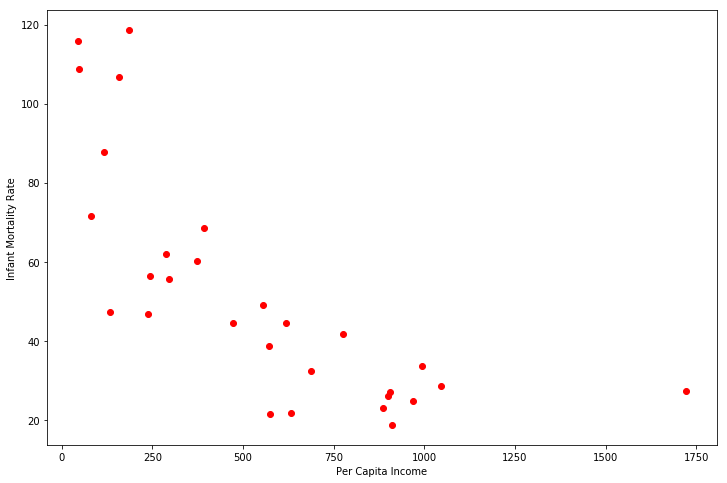

In [4]:
plt.plot(data['PCI'],data['Infant Mortality'],'ro')
plt.xlabel('Per Capita Income')
plt.ylabel('Infant Mortality Rate')
plt.show()

That weird point out to the right is kind of screwing things up, so let's drop it manually.

In [5]:
data = data.drop('United States')

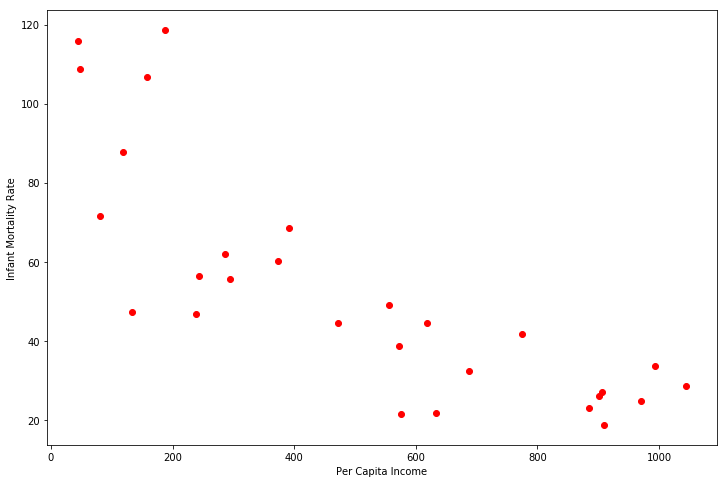

In [6]:
plt.plot(data['PCI'],data['Infant Mortality'],'ro')
plt.xlabel('Per Capita Income')
plt.ylabel('Infant Mortality Rate')
plt.show()

There's a clear, but noisy trend here.  Let's move forward with trying to see if we can predict Hungary's infant mortality rate by fitting a linear model to these other data.  In the parlance of last lecture, we have as a model
$$ F(x,w) = w_1 x + w_0, $$
where $x$ is the per capita income, and $w_0$ and $w_1$ are the model parameters intercept and slope.  We also need a cost function.  The classic example is least squares:
$$ I(y;F(x,w)) = \sum_{i=1}^n \frac{1}{2} [y_i - ( w_1 x + w_0)]^2. $$
We seek to find the values of $w_0$ and $w_1$ that make this function as small as it can be, or the parameter set that minimizes the objective function.  One simple way to find minimizing parameters is through exhaustive search.

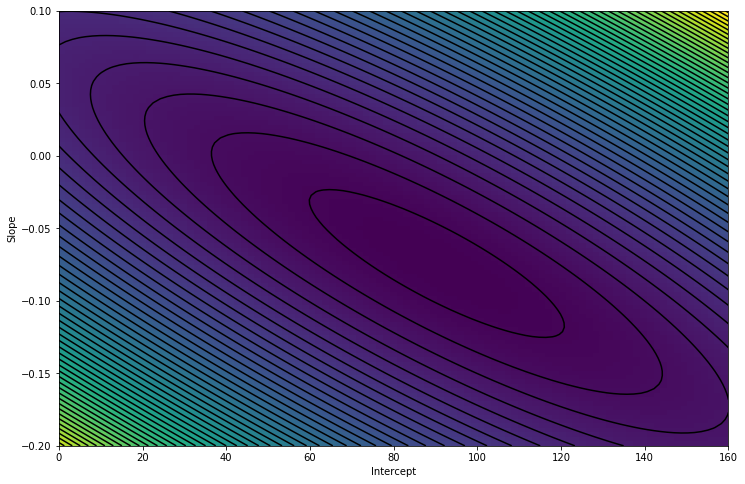

In [7]:
x = data['PCI'].as_matrix().astype(float)
y = data['Infant Mortality'].as_matrix().astype(float)

w0_sweep = np.linspace(0,160,100)
w1_sweep = np.linspace(0.1,-0.2,100)

W0_grid,W1_grid = np.meshgrid(w0_sweep,w1_sweep)
cost_list = np.zeros_like(W0_grid)

for i,w1 in enumerate(w1_sweep):
    for j,w0 in enumerate(w0_sweep):
        cost = 0.5*np.dot(y - (w1*x + w0),y - (w1*x + w0))
        cost_list[i,j] = cost

plt.pcolor(W0_grid,W1_grid,cost_list)
plt.contour(W0_grid,W1_grid,cost_list,50,colors='k')
plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.show()

We can clearly see that there is a minimum at around $w_0=80$ and $w_1=-0.05$.  But there has to be a better way to try all the possible parameter values.  This is very inefficient, and certainly impossible for models more challenging than this one.  Calculus suggests that there's a different approach.  We know that for a parabola, the derivative is zero at the minimum.  We can compute the derivatives directly for this problem:
$$ \frac{\partial I}{\partial w_0} = - \sum_{i=1}^n (y_i - w_1 x_i - w_0) $$
$$ \frac{\partial I}{\partial w_1} = - \sum_{i=1}^n (y_i - w_1 x_i - w_0)x_i $$
Setting these equal to zeros provides the two equations
$$ \sum_{i=1}^n (y_i) = \sum_{i=1}^n w_1 x_i + \sum_{i=1}^n w_0 $$.
$$ \sum_{i=1}^n (y_i x_i) = \sum_{i=1}^n w_1 x_i^2 + \sum_{i=1}^n w_0 x_i $$
This can be written more succinctly in matrix form as
$$ X^T X W = X^T y, $$
where $W = [w_0,w_1]^T$ and 
$$ X = \left[ \begin{array}{cc} 1 & x_0 \\ 1 & x_1 \\ \vdots & \vdots \\ 1 & x_n \end{array} \right]. $$ 
$X^T X$ is a 2 by 2 matrix, and $X^T y$ is 2 by 1 vector, and we can easily solve this equation for $W$ using any technique for solving systems of linear equations.

In [8]:
X = np.column_stack([np.ones_like(x),x])
w = np.linalg.solve(np.dot(X.T,X),np.dot(X.T,y))
X,w

(array([[  1.00000000e+00,   3.92000000e+02],
        [  1.00000000e+00,   1.18000000e+02],
        [  1.00000000e+00,   4.40000000e+01],
        [  1.00000000e+00,   1.58000000e+02],
        [  1.00000000e+00,   8.10000000e+01],
        [  1.00000000e+00,   3.74000000e+02],
        [  1.00000000e+00,   1.87000000e+02],
        [  1.00000000e+00,   9.93000000e+02],
        [  1.00000000e+00,   2.87000000e+02],
        [  1.00000000e+00,   9.70000000e+02],
        [  1.00000000e+00,   8.85000000e+02],
        [  1.00000000e+00,   5.75000000e+02],
        [  1.00000000e+00,   6.88000000e+02],
        [  1.00000000e+00,   4.80000000e+01],
        [  1.00000000e+00,   5.72000000e+02],
        [  1.00000000e+00,   2.39000000e+02],
        [  1.00000000e+00,   2.44000000e+02],
        [  1.00000000e+00,   4.72000000e+02],
        [  1.00000000e+00,   1.34000000e+02],
        [  1.00000000e+00,   6.33000000e+02],
        [  1.00000000e+00,   2.95000000e+02],
        [  1.00000000e+00,   9.060

Let's see how this value of $W$ compares to our error surface that we computed above 

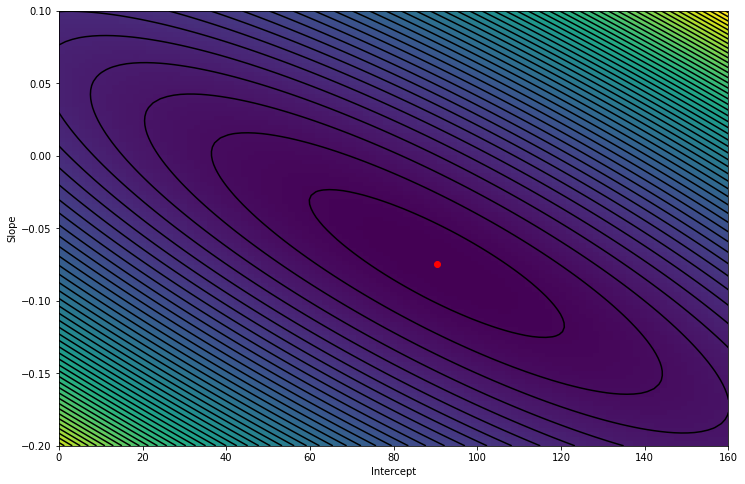

In [9]:
plt.pcolor(W0_grid,W1_grid,cost_list)
plt.contour(W0_grid,W1_grid,cost_list,50,colors='k')
plt.plot(w[0],w[1],'ro')
plt.xlabel('Intercept')
plt.ylabel('Slope')
plt.show()

Pretty Good!  And the fit to the data?

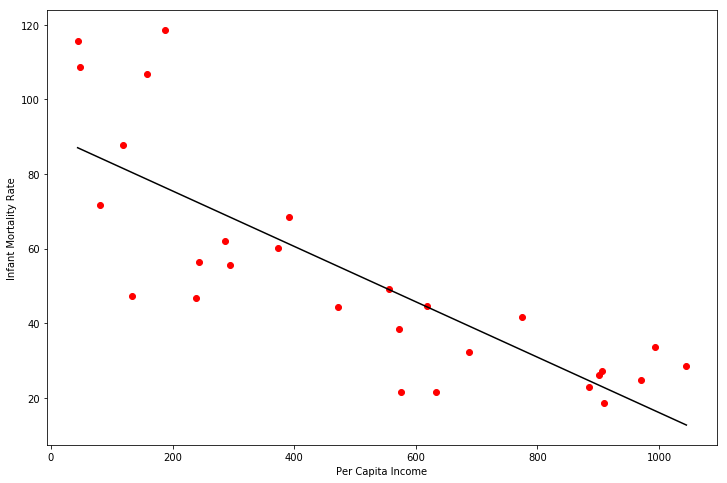

In [10]:
xhat = np.linspace(x.min(),x.max(),101)
Xhat = np.column_stack([np.ones_like(xhat),xhat])
yhat = np.dot(Xhat,w)

plt.plot(x,y,'ro')
plt.plot(xhat,yhat,'k-')
plt.xlabel('Per Capita Income')
plt.ylabel('Infant Mortality Rate')
plt.show()


And our prediction for Hungary?

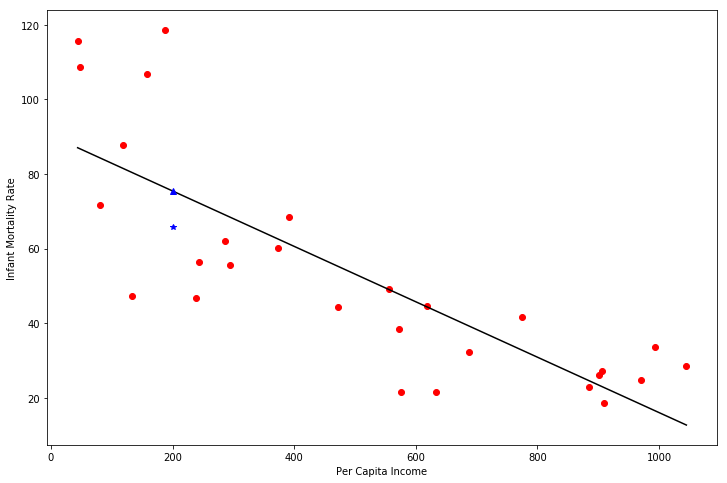

In [11]:
plt.plot(x,y,'ro')
plt.plot(xhat,yhat,'k-')
plt.plot(test_set['PCI'],test_set['Infant Mortality'],'b*')
plt.plot(test_set['PCI'],w[0] + w[1]*test_set['PCI'],'b^')
avg_rmse = np.sqrt(np.sum((np.dot(X,w) - y)**2)/len(y))


plt.xlabel('Per Capita Income')
plt.ylabel('Infant Mortality Rate')
plt.show()

Not too bad!  Our prediction is much better than if we had just randomly guessed.  We can say that we have learned something.  But can we do better with this data?  We've imposed some really strong assumptions by using a straight line as a model.  These assumptions are collectively referred to as the inductive bias, and every machine learning procedure has one.  Inductive bias is the structure that we impose upon our predictions, typically via model selection.  So, for this data, what happens if we select a model that has somewhat more explanatory power?

The 'linear' in linear regression doesn't actually refer to the fact that we modelled the data with a straight line.  In fact, it refers to the fact that we were able to find the minimizing parameter values through the solution of a linear set of equations (the normal equations given above).  Indeed, so long as our model is a linear combination of arbitrary functions of $x$, like
$$ w_0 + w_1 \exp (-(x-100)^2) + w_2 x^7 $$
is absolutely admissable, and the resulting equation to solve it is still
$$ X^T X W = X^T y, $$
where the columns of $X$ are the functions of the above expression.  These functions of $x$ are called 'basis functions', and are often denoted as $\phi_i(x)$.  For the above example, then there are three basis functions
$$ \phi_0(x)=1, \phi_1(x) = \exp(-(x-100)^2), \phi_2(x) = x^7. $$
Note that these are probably not very well selected basis functions: for real problems we will want to select them carefully for reasons we will discuss later.

We don't need to go too crazy here.  Instead, let's consider models of the form 
$$ w_0 + w_1 \tilde{x} + w_2 \tilde{x}^2 + \ldots + w_m \tilde{x}^m, $$
which is to say that our function can be represented as a polynomial of degree $m$, and our basis functions are the set of monomials:
$$ \phi_i(x) = x^i, \forall i\in[1,\ldots,m]. $$
Note that we've replaced $x$ with $\tilde{x}$, where:
$$
\tilde{x} = 2\frac{x-\mathrm{min}(x)}{\mathrm{max}(x) - \mathrm{min}(x)} - 1
$$
Which scales $x$ to the interval $\tilde{x}\in[1,1]$.  This helps to avoid numerical overflow and makes the problem a little bit better behaved.  We'll drop the tildes henceforth.  

This produces a matrix $X$ (also known as a design matrix), that looks like this:  
$$ X = 
\left[ \begin{array}{cccc} \phi_0(x_0) & \phi_1(x_0) & \cdots & \phi_m(x_0) \\ \phi_0(x_1) & \phi_1(x_1) & \cdots & \phi_m(x_1) \\ \vdots & \vdots & \ddots & \vdots \\ \phi_0(x_n) & \phi_1(x_n) & \cdots & \phi_m(x_n) \end{array} \right] =
\left[ \begin{array}{cccc} 1 & x_0 & \cdots & x_0 ^m \\ 1 & x_1 & \cdots & x_1^m \\ \vdots & \vdots & \ddots & \vdots \\ 1 & x_n & \cdots & x_n^m \end{array} \right]. $$

This matrix is also known as a Vandernonde matrix, and is common enough that numpy has a built-in function to produce it.  Let's see what happens for a quadratic polynomial (aka $m=2$): 


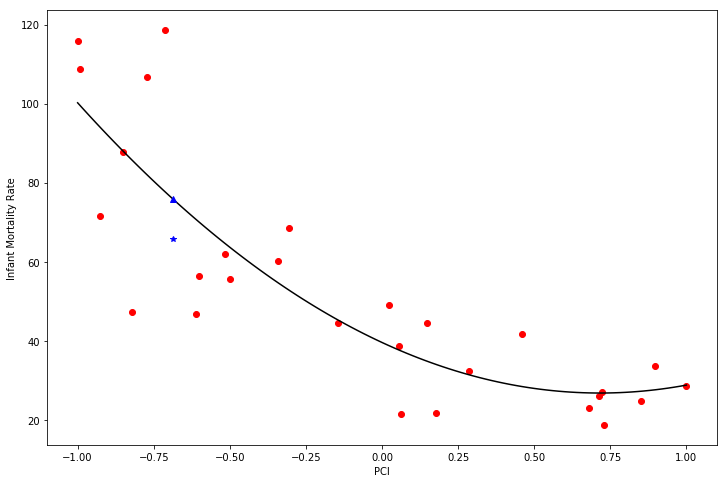

Avg. RMSE:  15.3412262537


In [12]:
x_tilde = 2*(x - x.min())/(x.max()-x.min()) - 1
xhat = 2*(xhat - x.min())/(x.max()-x.min()) - 1
x_test = 2*(test_set['PCI'] - x.min())/(x.max()-x.min()) - 1
x = x_tilde

degree = 2

X = np.vander(x,degree+1,increasing=True)
w = np.linalg.solve(np.dot(X.T,X),np.dot(X.T,y))

Xhat = np.vander(xhat,degree+1,increasing=True)
yhat = np.dot(Xhat,w)

avg_rmse = np.sqrt(np.sum((np.dot(X,w) - y)**2)/len(y))

plt.plot(x,y,'ro')
plt.plot(xhat,yhat,'k-')
plt.plot(x_test,test_set['Infant Mortality'],'b*')
plt.plot(x_test,w[0] + w[1]*x_test + w[2]*x_test**2,'b^')
plt.xlabel('PCI')
plt.ylabel('Infant Mortality Rate')
plt.show()

print "Avg. RMSE: ",avg_rmse

That didn't help our predictive accuracy much for Hungary, but we can see that in general, we've reduced the misfit for all the other points.  Let's keep going by increasing the polynomial degree to 5.


15.1993280766


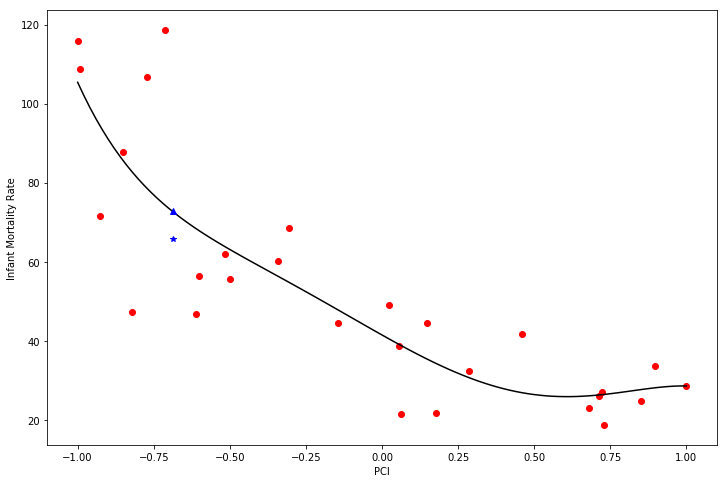

In [13]:
degree = 5

X = np.vander(x,degree+1,increasing=True)
w = np.linalg.solve(np.dot(X.T,X),np.dot(X.T,y))

Xhat = np.vander(xhat,degree+1,increasing=True)
yhat = np.dot(Xhat,w)

Xtest = np.vander([x_test],degree+1,increasing=True)
y_test = np.dot(Xtest,w)

avg_rmse = np.sqrt(np.sum((np.dot(X,w) - y)**2)/len(y))
print avg_rmse

plt.plot(x,y,'ro')
plt.plot(xhat,yhat,'k-')
plt.plot(x_test,test_set['Infant Mortality'],'b*')
plt.plot(x_test,y_test,'b^')
plt.xlabel('PCI')
plt.ylabel('Infant Mortality Rate')
plt.show()

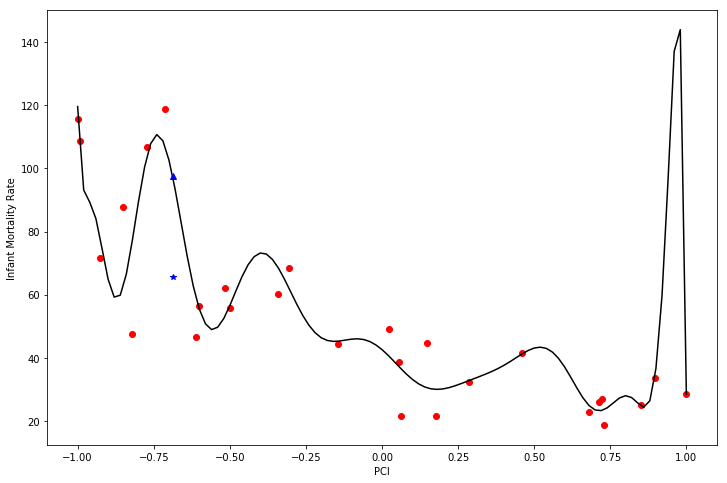

Avg. RMSE:  9.90093533628


In [14]:
degree = 17

X = np.vander(x,degree+1,increasing=True)
w = np.linalg.solve(np.dot(X.T,X),np.dot(X.T,y))

w_unreg = w

Xhat = np.vander(xhat,degree+1,increasing=True)
yhat = np.dot(Xhat,w)

Xtest = np.vander([x_test],degree+1,increasing=True)
y_test = np.dot(Xtest,w)

avg_rmse = np.sqrt(np.sum((np.dot(X,w) - y)**2)/len(y))

plt.plot(x,y,'ro')
plt.plot(xhat,yhat,'k-')
plt.plot(x_test,test_set['Infant Mortality'],'b*')
plt.plot(x_test,y_test,'b^')
plt.xlabel('PCI')
plt.ylabel('Infant Mortality Rate')
plt.show()

print "Avg. RMSE: ",avg_rmse

What's going on here?  Our average error in the training set is going down, but our prediction is getting worse!  The reason for this is straightforward: we're starting to fit the noise, rather than the signal.  There's a certain amount of error associated with a given label or measurement.  Some of this is from measurement error itself (Not every instance of infant mortality was counted, for example), and some of it is due to factors that we do not have any information about (perhaps a war drove up rates for a particular nation over the measurement period).  Our goal henceforth is not only to determine how to train models effectively, but also to select models in such a way that they give good predictive values for test data, rather than overfitting training data.    

One way of ensuring that we don't overfit is to carefully select our basis functions to be consistent with our a priori assumptions about the data.  This is useful in the case when we have some known physics that we're trying to find the parameters to.  For example, if we measure a series of positions for a cannonball under the influence of gravity in a vacuum in an attempt to infer the initial velocity and position, then we know that a parabola is the right shape to fit.  But we often don't know the functional relationship to start (this is a big difference between machine learning and other inverse methods).  One way to deal with this is a procedure known as regularization:  In regularization, we explicitly penalize some feature of the parameter values themselves (independent of misfit with the data).  We'll see many examples of regularization in this course, but a first example well-suited to the problem we're considering here is called variously Ridge Regression, Tikhonov Regularization, $L_2$ regularization, among other things.  The principle is straightforward.  We explicitly add a term to the cost function that is proportional to the sum of squares of the parameter values:
$$ I(y;F(x,w)) = \sum_{i=1}^n \frac{1}{2} [y_i - ( w_1 x + w_0)]^2 + \gamma \sum_{i=1}^m w_i^2 $$
Note that the bias weight $w_0$ is typically unpenalized.

Because the penalty term is quadratic, when we take the derivative we are left with a function that is linear in $w$, and as such we can still find the solution directly by solving a linear system of equations:
$$ (X^T X + \gamma \hat{\mathcal{I}}) W = X^T y, $$
where $\hat{\mathcal{I}}$ is the identity matrix with the entry corresponding to $w_0$ set to zero.  $\gamma$ is called the regularization parameter, and it controls the strength of the regularization.  Let's see how it influences the fit.

13.0028897882


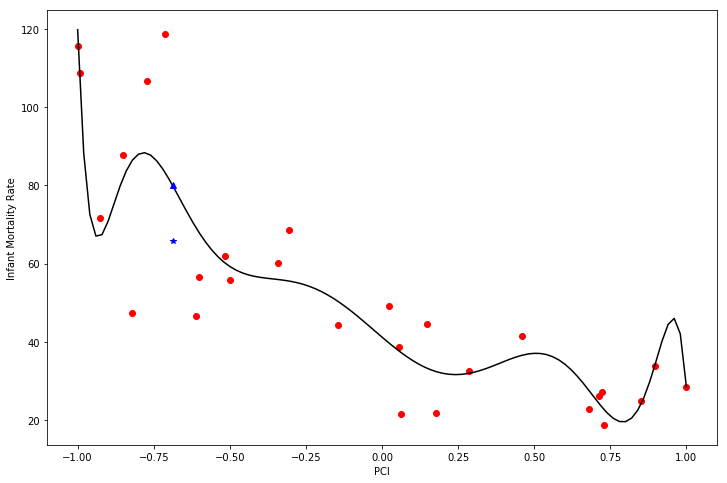

Avg. RMSE:  13.0028897882


In [15]:
degree = 17

gamma = 1e-4
Eye = np.eye(X.shape[1])
Eye[0,0] = 0

w = np.linalg.solve(np.dot(X.T,X) + gamma*Eye,np.dot(X.T,y))

w_small_gamma = w

yhat = np.dot(Xhat,w)
y_test = np.dot(Xtest,w)

avg_rmse = np.sqrt(np.sum((np.dot(X,w) - y)**2)/len(y))
print avg_rmse

plt.plot(x,y,'ro')
plt.plot(xhat,yhat,'k-')
plt.plot(x_test,test_set['Infant Mortality'],'b*')
plt.plot(x_test,y_test,'b^')
plt.xlabel('PCI')
plt.ylabel('Infant Mortality Rate')
plt.show()

print "Avg. RMSE: ",avg_rmse

15.2983553967


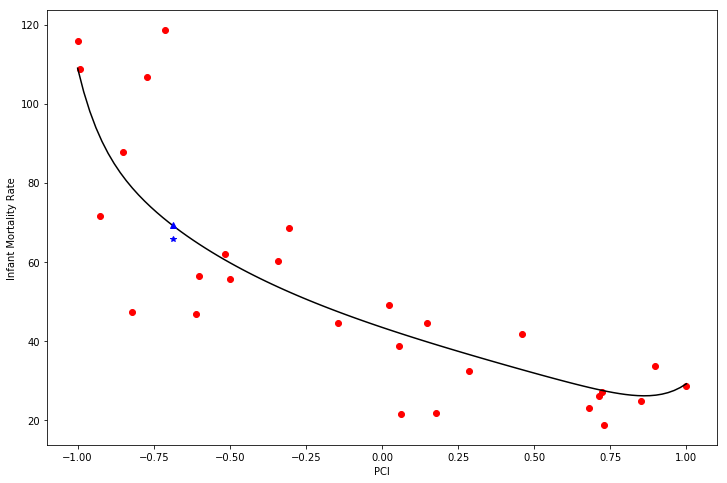

Avg. RMSE:  15.2983553967


In [16]:
degree = 17

gamma = 1.0

w = np.linalg.solve(np.dot(X.T,X) + gamma*Eye,np.dot(X.T,y))

w_large_gamma = w

yhat = np.dot(Xhat,w)
y_test = np.dot(Xtest,w)

avg_rmse = np.sqrt(np.sum((np.dot(X,w) - y)**2)/len(y))
print avg_rmse

plt.plot(x,y,'ro')
plt.plot(xhat,yhat,'k-')
plt.plot(x_test,test_set['Infant Mortality'],'b*')
plt.plot(x_test,y_test,'b^')
plt.xlabel('PCI')
plt.ylabel('Infant Mortality Rate')
plt.show()

print "Avg. RMSE: ",avg_rmse

It's also fun to look at the values of the parameters themselves under different regularization choices:


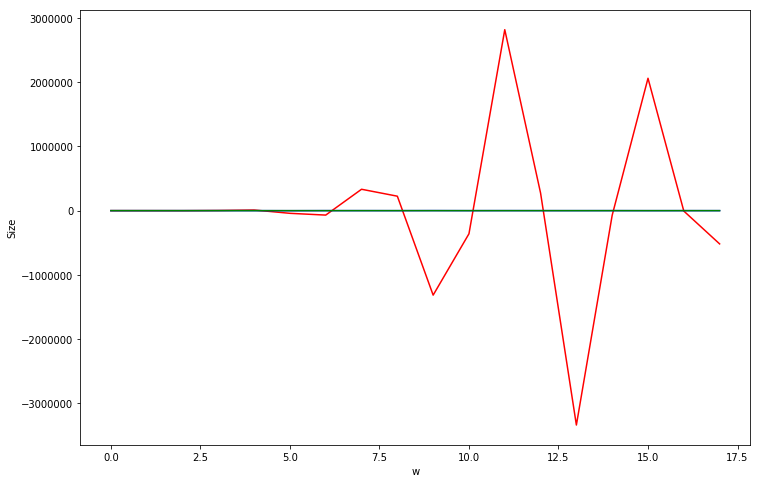

In [17]:
plt.plot(w_unreg,'r-')
plt.plot(w_small_gamma,'b-')
plt.plot(w_large_gamma,'g-')
plt.xlabel('w')
plt.ylabel('Size')
plt.show()

Or on a log scale:

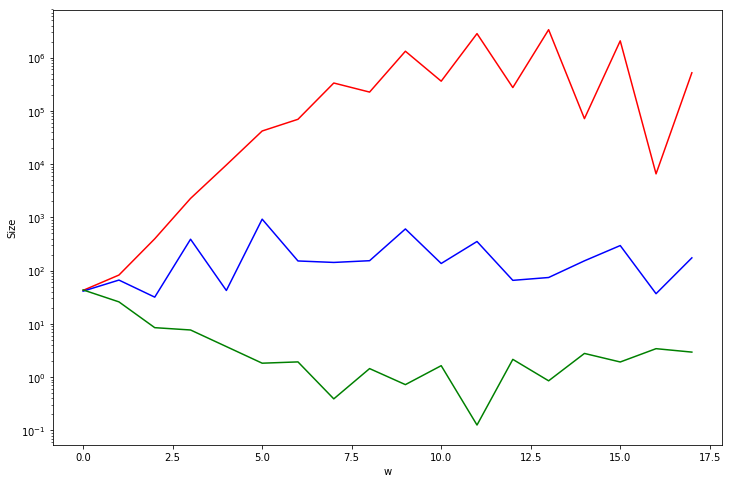

In [18]:
plt.semilogy(abs(w_unreg),'r-')
plt.semilogy(abs(w_small_gamma),'b-')
plt.semilogy(abs(w_large_gamma),'g-')
plt.xlabel('w')
plt.ylabel('Size')
plt.show()

As I mentioned above, the linear in linear regression comes from the ability to write models as linear combinations of known functions.  Just for fun, let's do this exercise for some periodic data that we'll make up.  In particular, let's look at a particularly challengin example, the sawtooth wave.    

In [ ]:
N_data = 41
x = np.linspace(-2,2,N_data)
xhat = np.linspace(-2,2,501)
y = x - np.floor(x) + np.random.randn(N_data)*0.1
plt.plot(x,y,'k.')
plt.show()

The natural set of functions for capturing a periodic function is the Fourier series.  Much like with polynomials, we need to select the complexity of our model.  As before, it's a tradeoff between overfitting and underfitting.  Let's start with the Fourier series up to their third terms.

The nice thing about design matrices is that their columns are the basis functions themselves, so we can easily plot them, just to get a sense of what we're working with before doing any fitting.

In [ ]:
degree = 3
X = np.column_stack([np.ones_like(x)]  
                  + [np.cos(N*2*np.pi*x) for N in range(1,degree+1)] 
                  + [np.sin(N*2*np.pi*x) for N in range(1,degree+1)])

Xhat = np.column_stack([np.ones_like(xhat)] + [np.cos(N*2*np.pi*xhat) for N in range(1,degree+1)] + [np.sin(N*2*np.pi*xhat) for N in range(1,degree+1)])

In [ ]:
for i in range(0,2*degree+1):
    plt.plot(xhat,Xhat[:,i],alpha=0.5)
plt.xlim(0,1)
plt.show()

The normal equations do not change.  We still have to solve
$$ (X^T X + \gamma \mathcal{I} \mathbf{w} = X^T y $$ 
to get the optimal model parameters $\mathbf{w}$.    

In [ ]:
gamma = 1e-3
Eye = np.eye(X.shape[1])
Eye[0,0] = 0
w_0 = np.linalg.solve(np.dot(X.T,X) + gamma*Eye,np.dot(X.T,y))

In [ ]:
plt.plot(x,y,'k.')
plt.plot(xhat,np.dot(Xhat,w_0),'r-')
plt.show()

In [ ]:
degree = 8
X = np.column_stack([np.ones_like(x)]  
                  + [np.cos(N*2*np.pi*x) for N in range(1,degree+1)] 
                  + [np.sin(N*2*np.pi*x) for N in range(1,degree+1)])

Xhat = np.column_stack([np.ones_like(xhat)] + [np.cos(N*2*np.pi*xhat) for N in range(1,degree+1)] + [np.sin(N*2*np.pi*xhat) for N in range(1,degree+1)])


In [ ]:
gamma = 1e-1
Eye = np.eye(X.shape[1])
Eye[0,0] = 0
w_1 = np.linalg.solve(np.dot(X.T,X) + gamma*Eye,np.dot(X.T,y))
plt.plot(x,y,'k.')
plt.plot(xhat,np.dot(Xhat,w_1),'r-')
plt.show()

In [ ]:
plt.plot(w_0)
plt.plot(w_1)
plt.show()

The 'opposite' to a global basis like the Fourier series is a local basis, which can sometimes be useful, particularly for tasks like interpolation of data that is known to have structure that isn't well captured by polynomials.  One example of such a local basis is the squared exponential radial basis function given by
$$ \phi_{rbf}(x,x_0,L) = \exp \left[-\frac{1}{2} \frac{(x-x_0)^2}{L^2} \right], $$
where we define $L$ and $x_0$ such that there is plenty of overlap.  For example

In [ ]:
x = np.random.rand(11)*2 - 1
xhat = np.linspace(-1,1,201)
y = np.sin(2*np.pi*x) + np.random.randn(11)*0.5
x_centers = np.linspace(-1,1,11)
L = 0.5*(x_centers[1]-x_centers[0])
X = np.column_stack([np.exp(-1./2.*(x-x_c)**2/(L**2)) for x_c in x_centers])
Xhat = np.column_stack([np.exp(-1./2.*(xhat-x_c)**2/(L**2)) for x_c in x_centers])

for i in range(Xhat.shape[1]):
    plt.plot(xhat,Xhat[:,i])
plt.show()


In [ ]:
plt.plot(x,y,'k.')
plt.show()

In [ ]:
gamma = 1e-1
Eye = np.eye(X.shape[1])
w = np.linalg.solve(np.dot(X.T,X) + gamma*Eye,np.dot(X.T,y))
plt.plot(x,y,'k.')
plt.plot(xhat,np.dot(Xhat,w),'r-')
for i in range(len(w)):
    plt.plot(xhat,Xhat[:,i]*w[i],alpha=0.5,lw=1.0)
plt.show()